In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import os
import FiShPy.FiSh as FS
from scipy.spatial import distance
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
%matplotlib inline

In [2]:
os.chdir('../../Data/Preprocessed/')
data = {}
locations = ['centar', 'gazibaba', 'karpos', 'kicevo', 'kumanovo', 'lisice', 'miladinovci', 'tetovo']
for loc in locations:
    data[loc] = pd.read_csv(loc + '.csv')
    data[loc]['time'] = pd.to_datetime(data[loc]['time'], infer_datetime_format=True)

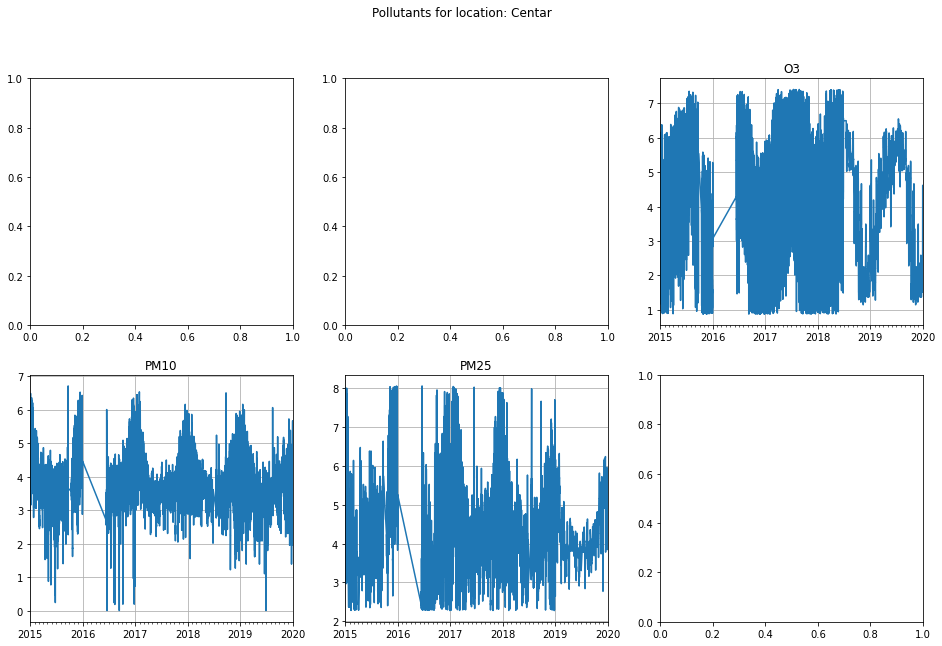

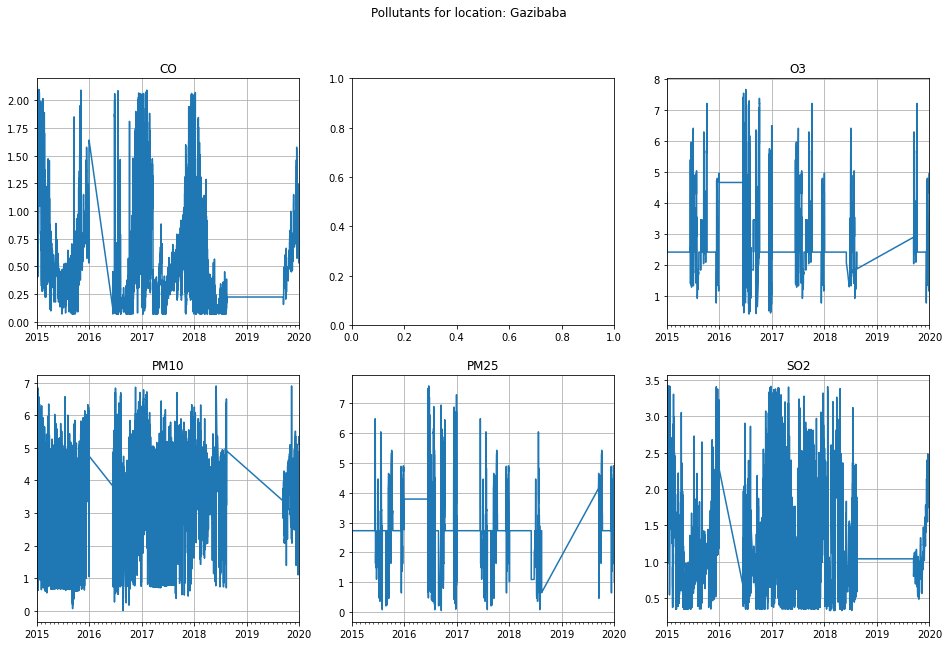

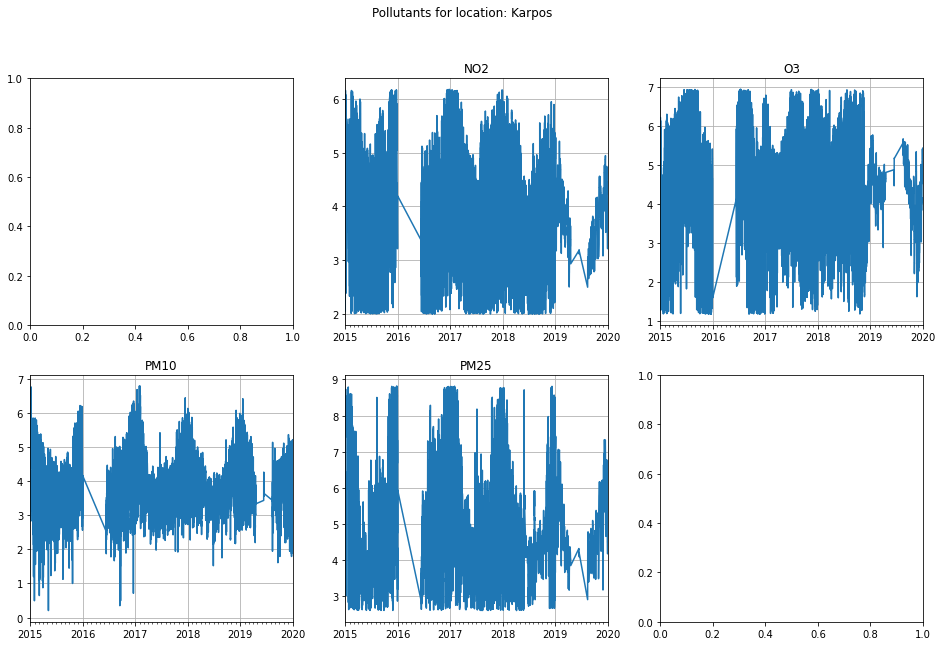

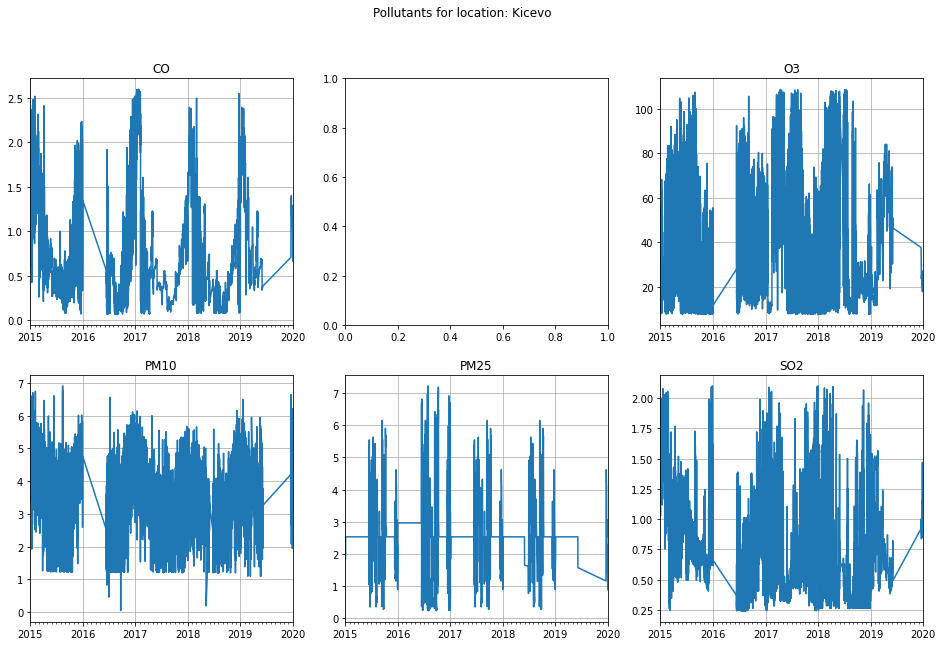

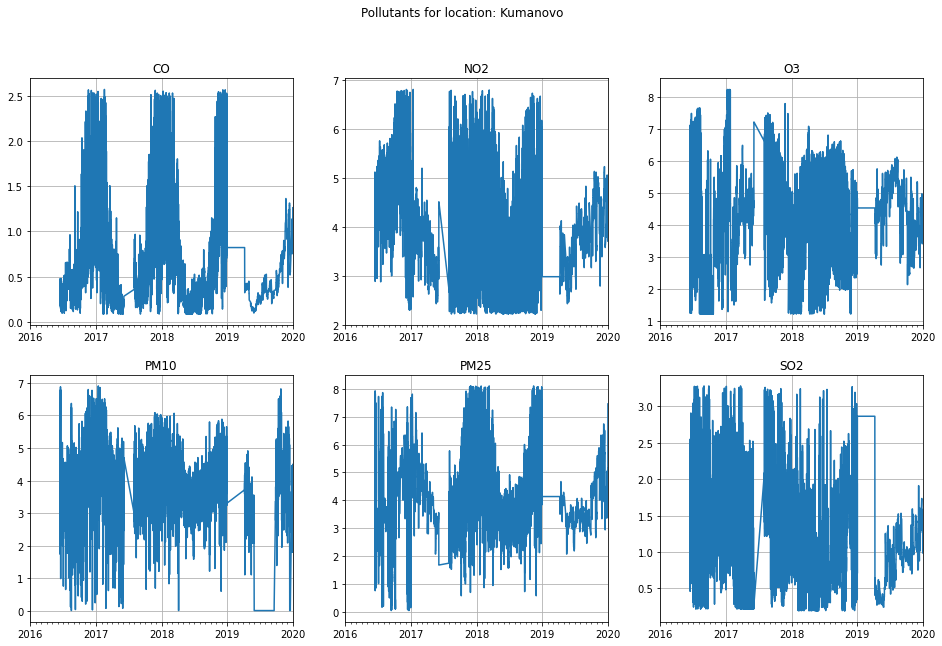

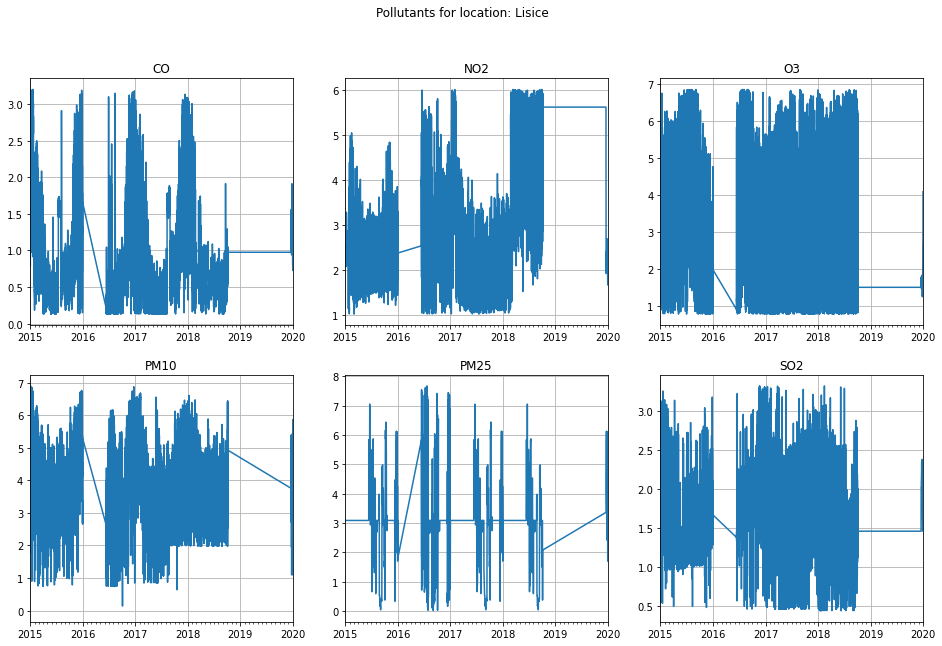

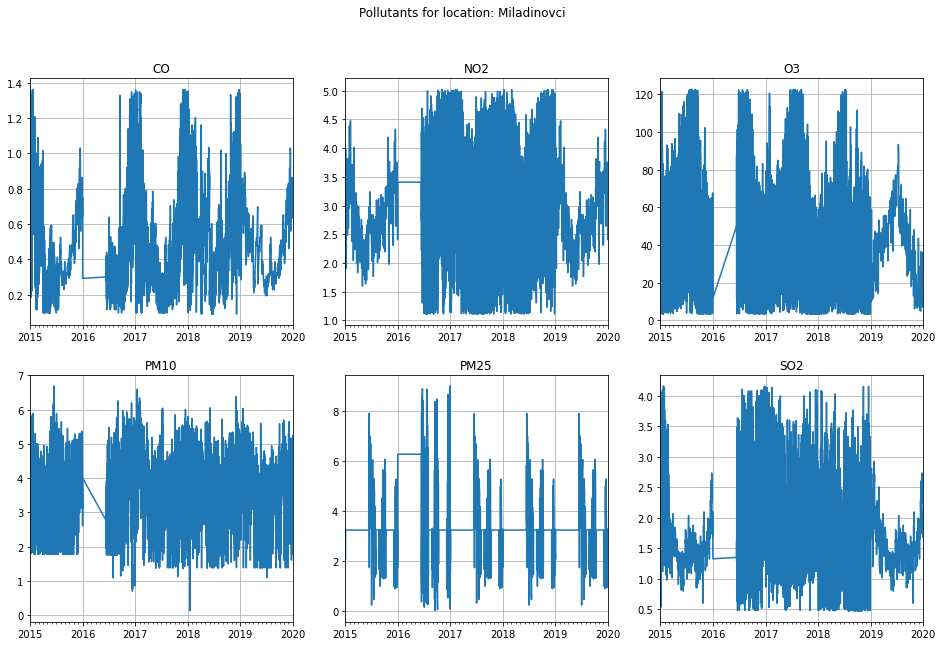

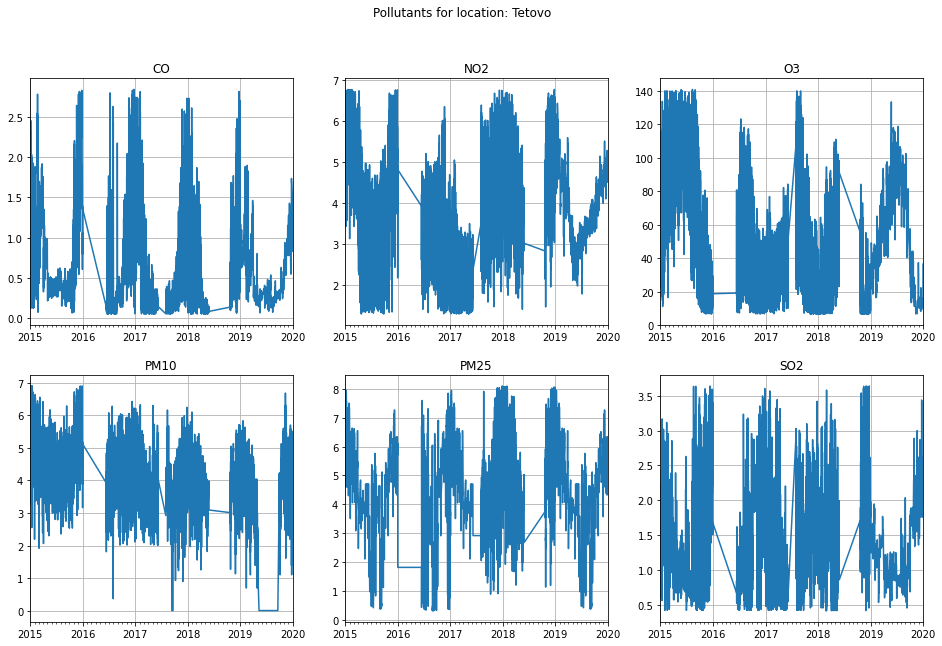

In [3]:
pollutants = ['CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
for loc in locations:
    fig = plt.figure(figsize=(16,10))
    fig.subplots(2,3)
    fig.suptitle("Pollutants for location: " + loc.capitalize())
    for i, p in enumerate(pollutants):
        if p in data[loc].columns:
            ax = plt.subplot(2,3,i+1)
            # format the ticks
            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(years_fmt)
            ax.xaxis.set_minor_locator(months)

            # round to nearest years.
            datemin = np.datetime64(data[loc]['time'].iloc[0], 'Y')
            datemax = np.datetime64(data[loc]['time'].iloc[-1], 'Y')
            ax.set_xlim(datemin, datemax)

            # format the coords message box
            ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
            ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
            ax.grid(True)

            plt.plot(data[loc]['time'],data[loc][p])
            plt.title(p)
plt.show()

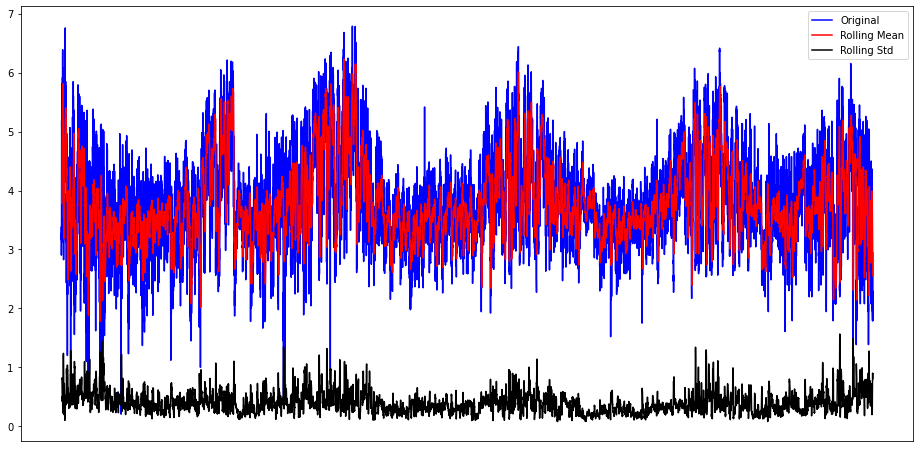

In [4]:
rolmean = data['karpos']['PM10'].rolling(window=30).mean()
rolstd = data['karpos']['PM10'].rolling(window=30).std()

fig = plt.figure(figsize=(16,8))
orig = plt.plot(data['karpos']['PM10'], color='blue', label='Original')
orig = plt.plot(rolmean, color='red', label='Rolling Mean')
orig = plt.plot(rolstd, color='black', label='Rolling Std')

plt.xticks([])
plt.legend(loc='best')
plt.show()

In [ ]:
# Stationarity test, not working
from statsmodels.tsa.stattools import adfuller
from functools import reduce

for loc in locations:
    for p in pollutants:
        if p in data[loc].columns:
            if reduce(lambda a,b: not (a or b), data[loc][p].isna()):
                print("Results of Dickey-Fuller Test on {} pollutant at {} location".format(p, loc))
                dftest = adfuller(data[loc][p], autolag='AIC')

                dfoutput = pd.Series(dftest[:4], index=['Test Statistic', 'p-value', 
                                                        '#Lags used', '#Observations used'])
                for k, v in dftest[4].items():
                    dfoutput['Critical Value (%s)'%k] = v

                print(dfoutput + '/n')

# Clustering

## On whole time series

In [5]:
fsp_pm10 = pd.DataFrame(columns=['loc','sep','fim'])
sep, fim = [], []
for loc in locations:
    h = FS.dpik(data[loc]['PM10'])
    SEP, FIM, FSC = FS.SEP_FIM(data[loc]['PM10'], h, log_trsf=False)
    sep.append(SEP)
    fim.append(FIM)
fsp_pm10['loc'] = locations
fsp_pm10['sep'] = sep
fsp_pm10['fim'] = fim
fsp_pm10.set_index('loc', inplace=True)
display(fsp_pm10)

,sep,fim
loc,,
centar,0.513395,2.939560
gazibaba,1.117808,3.711616
karpos,0.586873,2.084138
kicevo,0.754172,1.922404
kumanovo,0.609581,55.912039
lisice,0.880042,1.667952
miladinovci,0.563775,2.330096
tetovo,0.641616,72.913561


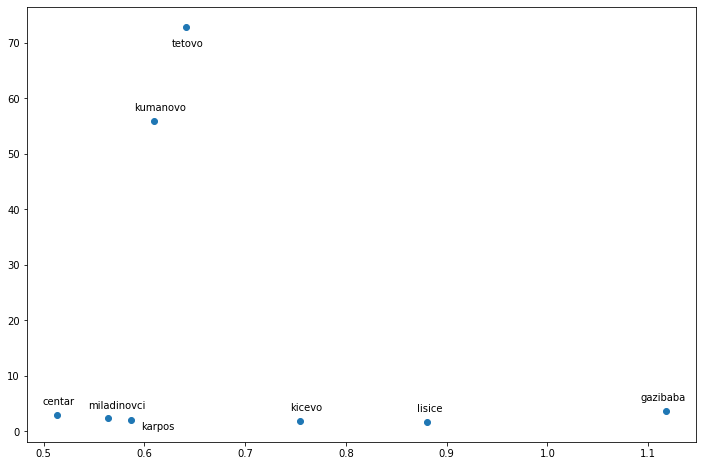

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(fsp_pm10['sep'], fsp_pm10['fim'])
xytext = [(-15, 10), (-25, 10), (10, -10), (-10, 10), (-20, 10), (-10, 10), (-20, 10), (-15, -20)]
for i, loc in enumerate(fsp_pm10.index.values):
    ax.annotate(loc, (fsp_pm10['sep'][i], fsp_pm10['fim'][i]),
                xytext=xytext[i], textcoords='offset points')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.9184764755938651
For n_clusters = 3 The average silhouette_score is : 0.7365244055453761
For n_clusters = 4 The average silhouette_score is : 0.3986177376478309
For n_clusters = 5 The average silhouette_score is : 0.26792989860862026


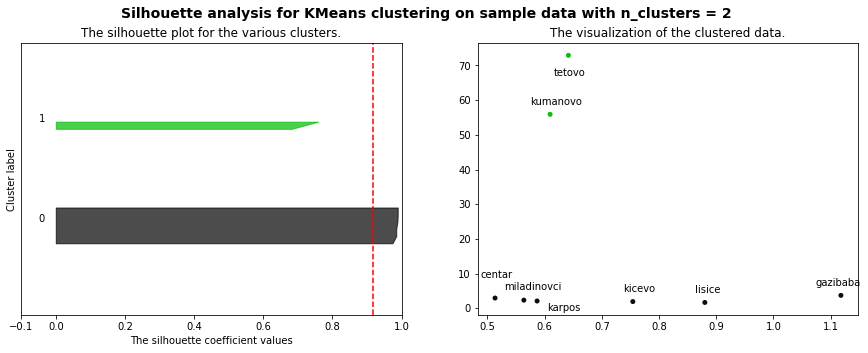

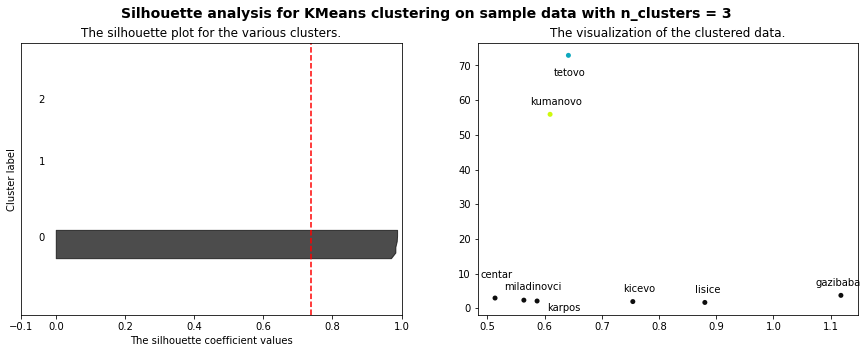

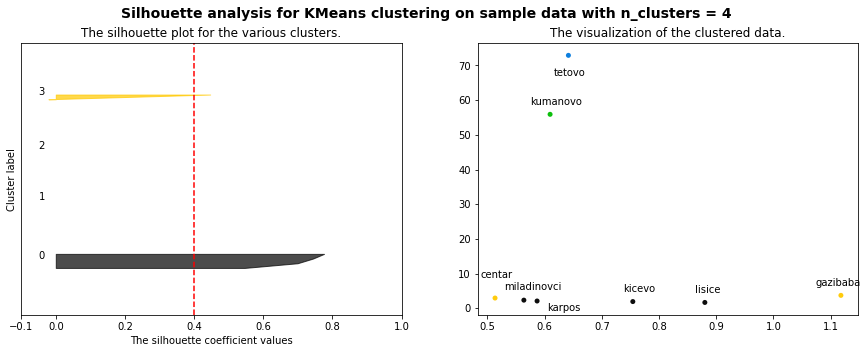

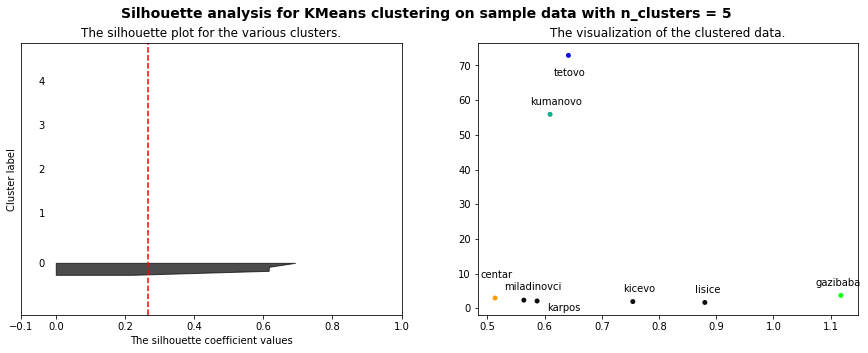

In [7]:
range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(fsp_pm10) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=8)
    cluster_labels = clusterer.fit_predict(fsp_pm10)

    silhouette_avg = silhouette_score(fsp_pm10, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(fsp_pm10, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    clrs = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(fsp_pm10['sep'], fsp_pm10['fim'], marker='.', s=100, lw=0, alpha=0.95, c=clrs, edgecolor='k')
    xytext = [(-15, 20), (-25, 10), (10, -10), (-10, 10), (-20, 10), (-10, 10), (-20, 10), (-15, -20)]
    for i, loc in enumerate(fsp_pm10.index.values):
        ax2.annotate(loc, (fsp_pm10['sep'][i], fsp_pm10['fim'][i]),
                xytext=xytext[i], textcoords='offset points')
    # centers = clusterer.cluster_centers_
    # ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    # for i, c in enumerate(centers):
        # ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## On monthly basis

In [8]:
fsp_monthly_pm10 = pd.DataFrame(columns=['loc_mnth','sep','fim'])
sep, fim, loc_months = [], [], []
for loc in locations:
    loc_df = data[loc]
    for month in range(1,13):
        h = FS.dpik(loc_df.loc[pd.DatetimeIndex(loc_df.time).month == month, 'PM10'].reset_index(drop=True))
        SEP, FIM, FSC = FS.SEP_FIM(loc_df.loc[pd.DatetimeIndex(loc_df.time).month == month,
                                              'PM10'].reset_index(drop=True), h, log_trsf=False)
        sep.append(SEP)
        fim.append(FIM)
        loc_months.append(loc + str(month))
fsp_monthly_pm10['loc_mnth'] = loc_months
fsp_monthly_pm10['sep'] = sep
fsp_monthly_pm10['fim'] = fim
fsp_monthly_pm10.set_index('loc_mnth', inplace=True)
display(fsp_monthly_pm10)

,sep,fim
loc_mnth,,
centar1,0.801448,1.418747
centar2,0.585258,2.045951
centar3,0.223292,5.324442
centar4,0.252205,7.981779
centar5,0.191839,5.597927
...,...,...
tetovo8,0.284930,24.937972
tetovo9,0.494840,12.210485
tetovo10,0.465487,2.415208


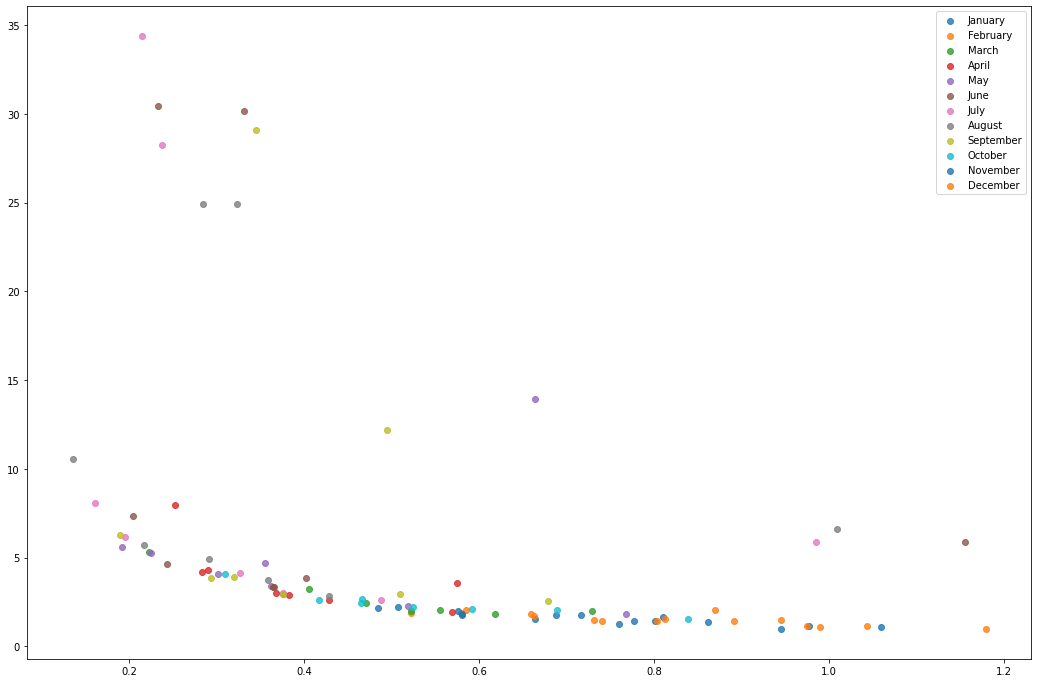

In [9]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(12):
    plt.scatter(fsp_monthly_pm10['sep'].iloc[i::12],
                fsp_monthly_pm10['fim'].iloc[i::12], alpha=0.8)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
      'August', 'September', 'October', 'November', 'December']
plt.legend(months)
plt.show()

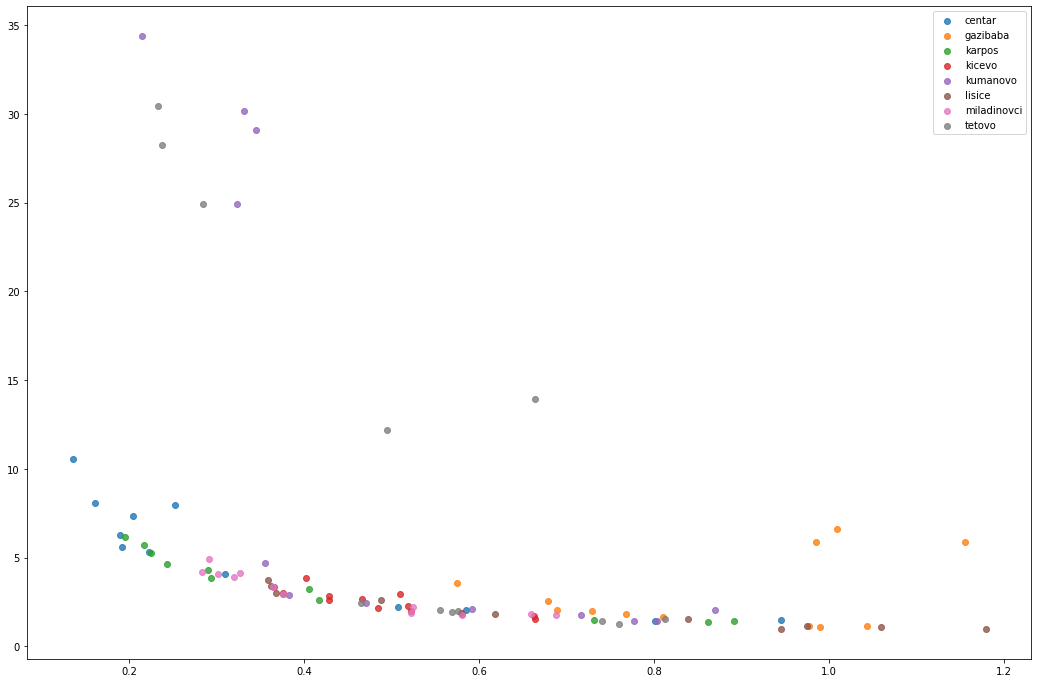

In [10]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(8):
    plt.scatter(fsp_monthly_pm10['sep'].iloc[i*12:i*12+12],
                fsp_monthly_pm10['fim'].iloc[i*12:i*12+12], alpha=0.8)
    plt.legend(locations)
plt.show()

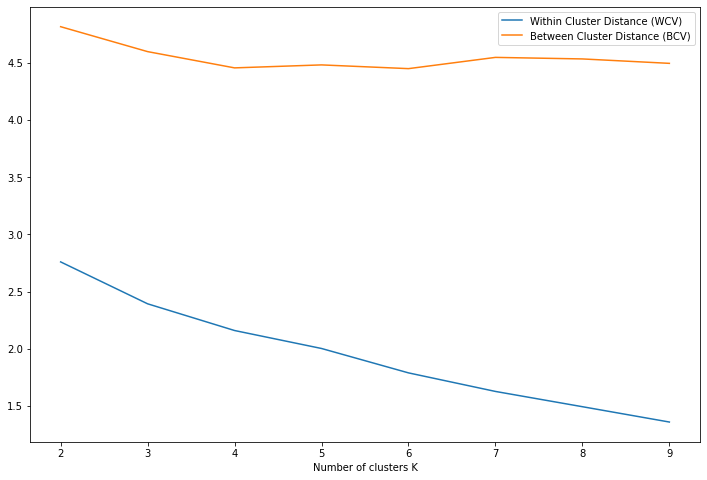

In [11]:
from math import log10
fig1 = plt.figure(figsize=(12, 8))
wcv = {}
bcv = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,max_iter=1000).fit(fsp_monthly_pm10)
    wcv[k] = kmeans.inertia_ 
    centers = kmeans.cluster_centers_
    BCV = 0
    for i in range(len(centers)):
        for j in range(len(centers)):
            BCV += distance.euclidean(centers[i], centers[j])**2
    if(k==1):
        bcv[1] = 0
    else:
        bcv[k] = BCV/(k*(k-1))*100
plt.plot(list(wcv.keys()), [log10(x) for x in wcv.values()],
         label="Within Cluster Distance (WCV)")
plt.plot(list(bcv.keys()), [log10(x) for x in bcv.values()],
         label="Between Cluster Distance (BCV)")
plt.xlabel("Number of clusters K")
plt.legend()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.8961856062338267
For n_clusters = 3 The average silhouette_score is : 0.6925075458209887
For n_clusters = 4 The average silhouette_score is : 0.6555090297964784
For n_clusters = 5 The average silhouette_score is : 0.6462061364278645
For n_clusters = 6 The average silhouette_score is : 0.6049121163327561
For n_clusters = 7 The average silhouette_score is : 0.5987850590533794
For n_clusters = 8 The average silhouette_score is : 0.5647778915900719
For n_clusters = 9 The average silhouette_score is : 0.5779933613561324


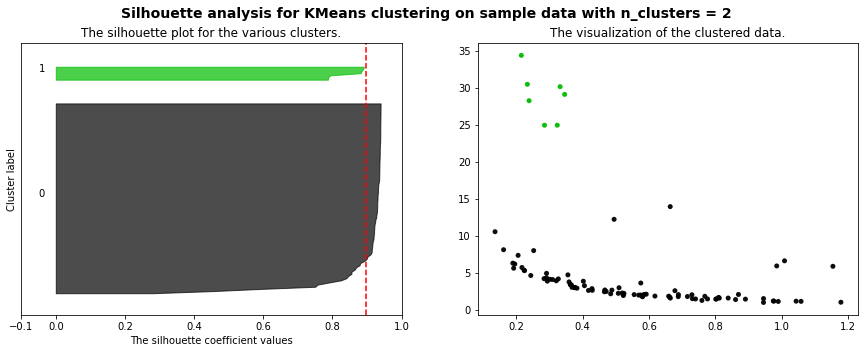

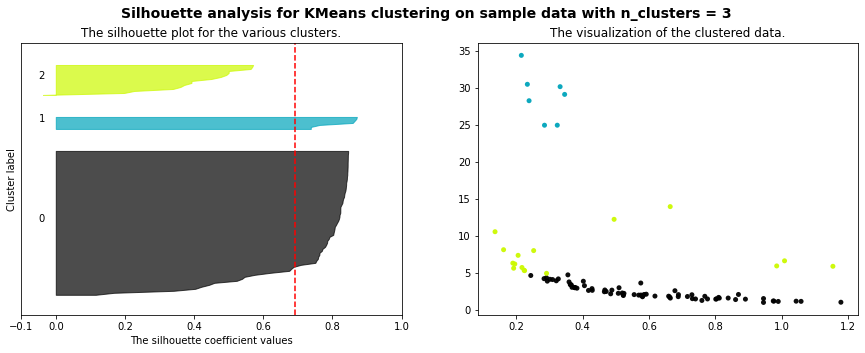

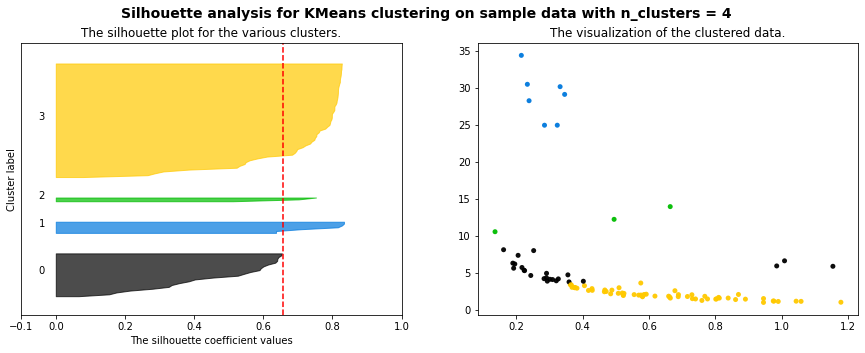

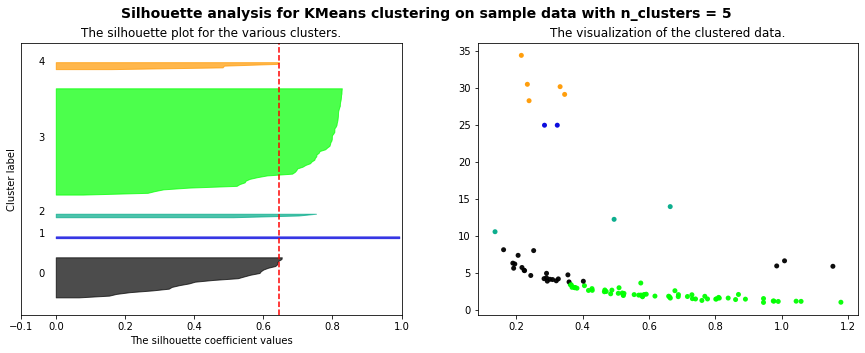

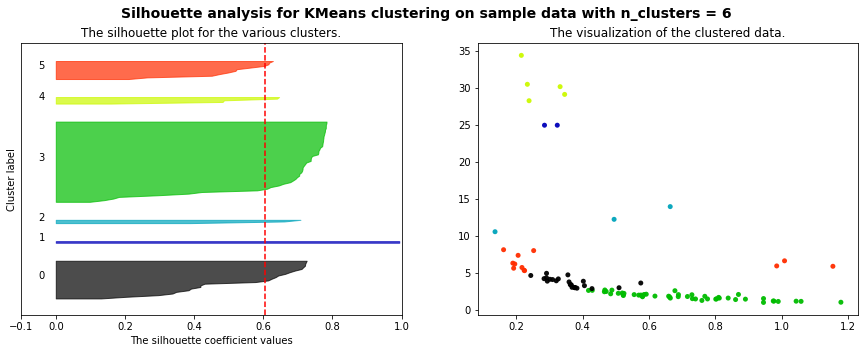

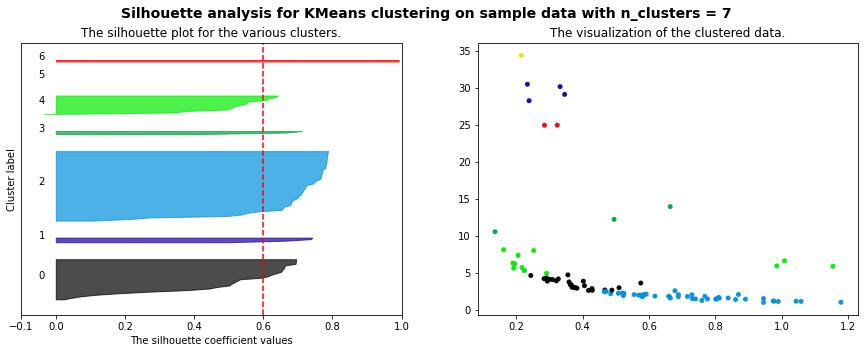

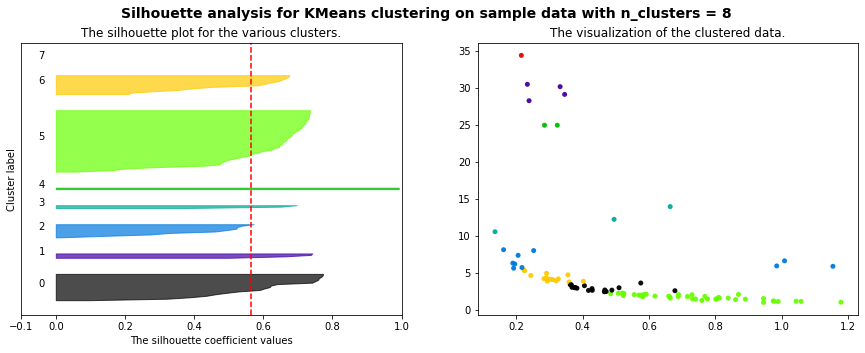

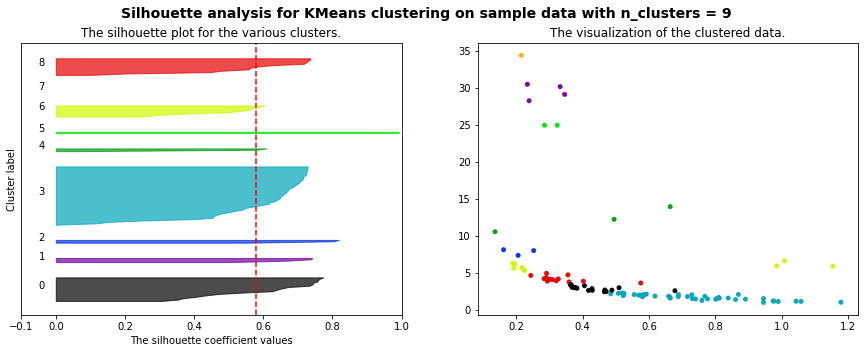

In [12]:
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(fsp_monthly_pm10) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=8)
    cluster_labels = clusterer.fit_predict(fsp_monthly_pm10)

    silhouette_avg = silhouette_score(fsp_monthly_pm10, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(fsp_monthly_pm10, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    clrs = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(fsp_monthly_pm10['sep'], fsp_monthly_pm10['fim'], marker='.',
                s=100, lw=0, alpha=0.95, c=clrs, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## On seasonal basis

In [13]:
fsp_seasonal_pm10 = pd.DataFrame(columns=['loc_ssn','sep','fim'])
sep, fim, loc_ssn = [], [], []
seasons = {'spring':[3, 4, 5], 'summer':[6, 7, 8], 'autumn':[9, 10, 11], 'winter':[12, 1, 2]}
for loc in locations:
    loc_df = data[loc]
    for name, season in seasons.items():
        h = FS.dpik(loc_df.loc[pd.DatetimeIndex(loc_df.time).month.isin(season),
                               'PM10'].reset_index(drop=True))
        SEP, FIM, FSC = FS.SEP_FIM(loc_df.loc[pd.DatetimeIndex(loc_df.time).month.isin(season),
                                              'PM10'].reset_index(drop=True), h, log_trsf=False)
        sep.append(SEP)
        fim.append(FIM)
        loc_ssn.append(loc + "_" + name)
fsp_seasonal_pm10['loc_ssn'] = loc_ssn
fsp_seasonal_pm10['sep'] = sep
fsp_seasonal_pm10['fim'] = fim
fsp_seasonal_pm10.set_index('loc_ssn', inplace=True)
display(fsp_seasonal_pm10)

,sep,fim
loc_ssn,,
centar_spring,0.248409,4.951472
centar_summer,0.168198,8.575201
centar_autumn,0.408071,2.807088
centar_winter,0.854224,1.327414
gazibaba_spring,0.732327,4.063163
gazibaba_summer,1.046334,10.166149
gazibaba_autumn,0.829897,1.684133
gazibaba_winter,1.081692,1.076147
karpos_spring,0.343206,3.474501


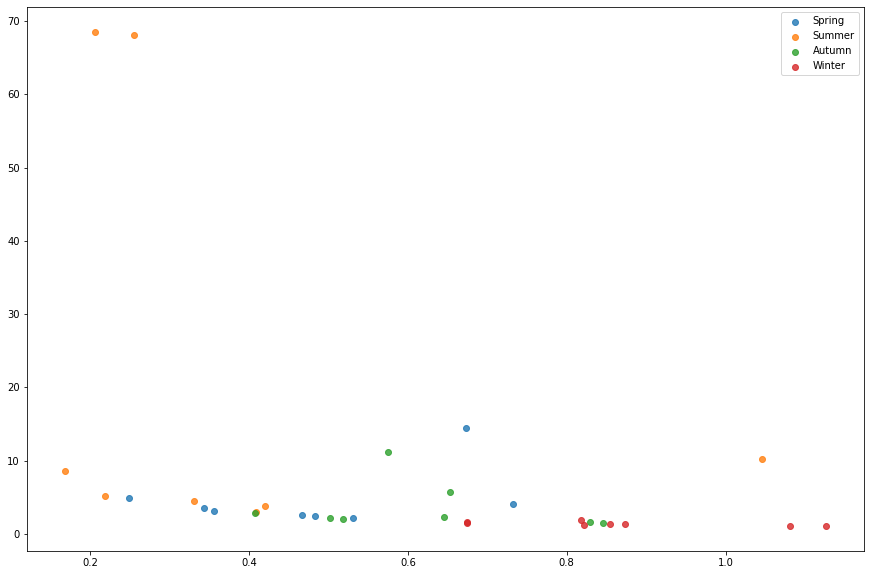

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(4):
    plt.scatter(fsp_seasonal_pm10['sep'].iloc[i::4],
                fsp_seasonal_pm10['fim'].iloc[i::4], alpha=0.8)
plt.legend([x.capitalize() for x in seasons.keys()])
plt.show()

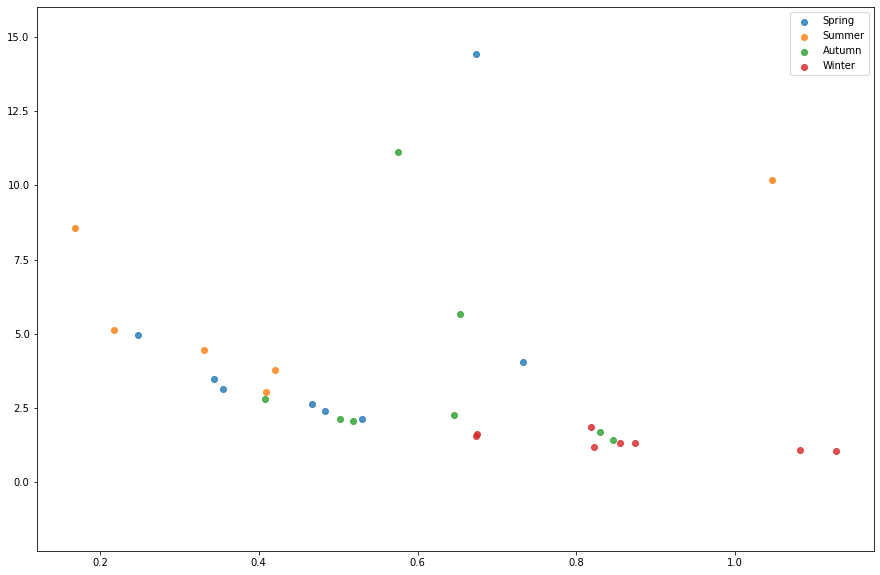

In [24]:
# exclude the two outliers from plot, in order to see other points more clearly
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(4):
    plt.scatter(fsp_seasonal_pm10['sep'].iloc[i::4],
                fsp_seasonal_pm10['fim'].iloc[i::4], alpha=0.8)
plt.legend([x.capitalize() for x in seasons.keys()])
plt.ylim(top=16)
plt.show()

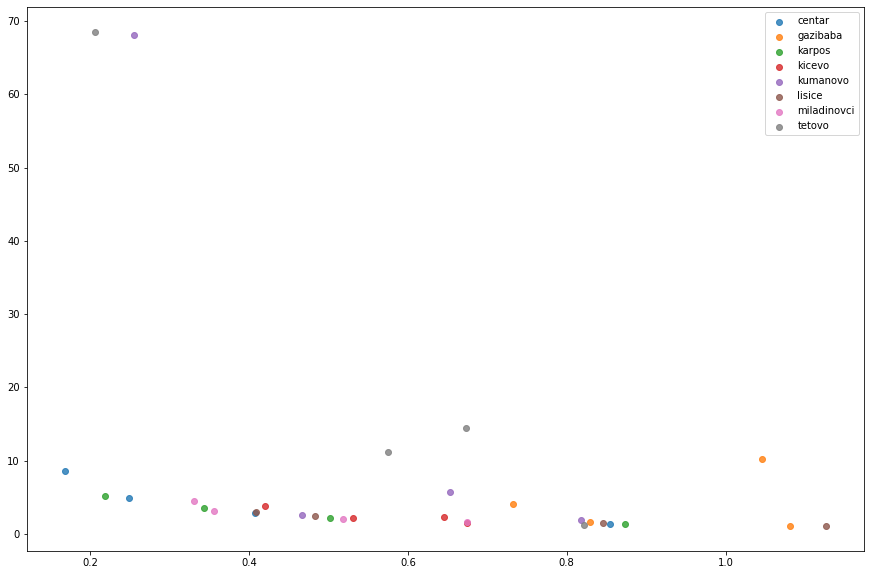

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(8):
    plt.scatter(fsp_seasonal_pm10['sep'].iloc[i*4:i*4+4],
                fsp_seasonal_pm10['fim'].iloc[i*4:i*4+4], alpha=0.8)
    plt.legend(locations)
plt.show()

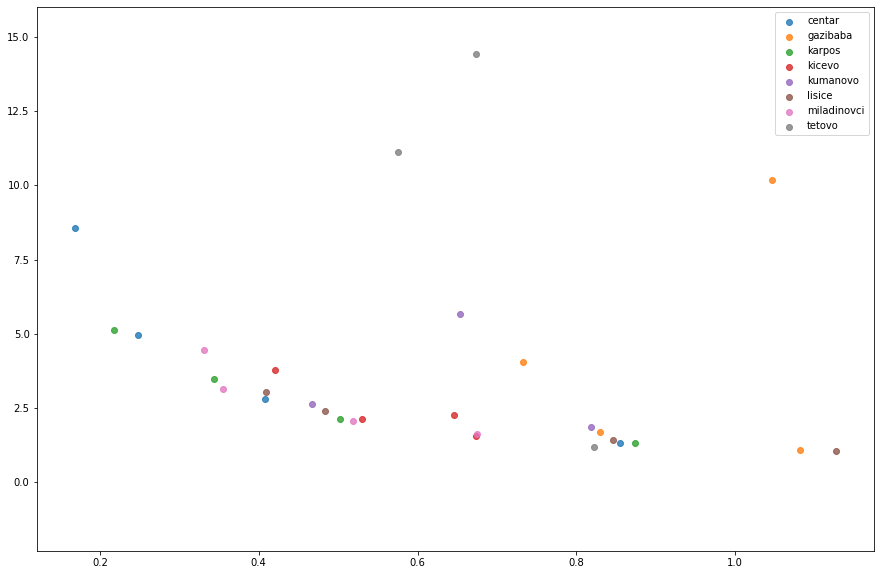

In [26]:
# exclude the two outliers from plot, in order to see other points more clearly
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(8):
    plt.scatter(fsp_seasonal_pm10['sep'].iloc[i*4:i*4+4],
                fsp_seasonal_pm10['fim'].iloc[i*4:i*4+4], alpha=0.8)
    plt.legend(locations)
plt.ylim(top=16)
plt.show()

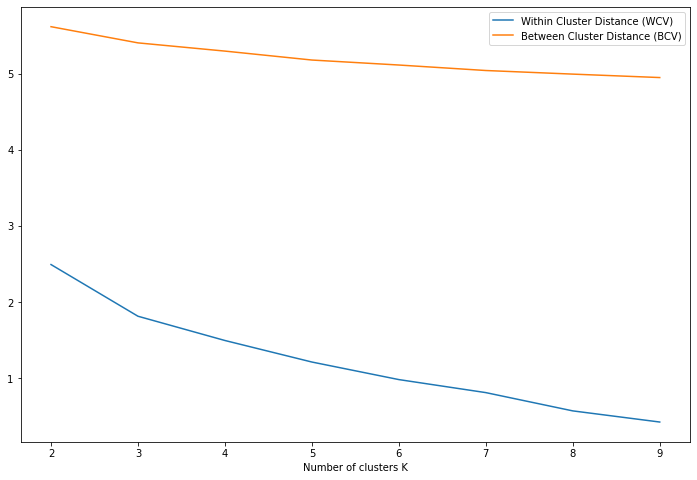

In [16]:
from math import log10
fig1 = plt.figure(figsize=(12, 8))
wcv = {}
bcv = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,max_iter=1000).fit(fsp_seasonal_pm10)
    wcv[k] = kmeans.inertia_ 
    centers = kmeans.cluster_centers_
    BCV = 0
    for i in range(len(centers)):
        for j in range(len(centers)):
            BCV += distance.euclidean(centers[i], centers[j])**2
    if(k==1):
        bcv[1] = 0
    else:
        bcv[k] = BCV/(k*(k-1))*100
plt.plot(list(wcv.keys()), [log10(x) for x in wcv.values()],
         label="Within Cluster Distance (WCV)")
plt.plot(list(bcv.keys()), [log10(x) for x in bcv.values()],
         label="Between Cluster Distance (BCV)")
plt.xlabel("Number of clusters K")
plt.legend()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.9510284489257046
For n_clusters = 3 The average silhouette_score is : 0.7891485313190807
For n_clusters = 4 The average silhouette_score is : 0.6196141948125319
For n_clusters = 5 The average silhouette_score is : 0.6068275883719393
For n_clusters = 6 The average silhouette_score is : 0.566205635541246
For n_clusters = 7 The average silhouette_score is : 0.5508610009775988
For n_clusters = 8 The average silhouette_score is : 0.527956523844399
For n_clusters = 9 The average silhouette_score is : 0.5066560246290122


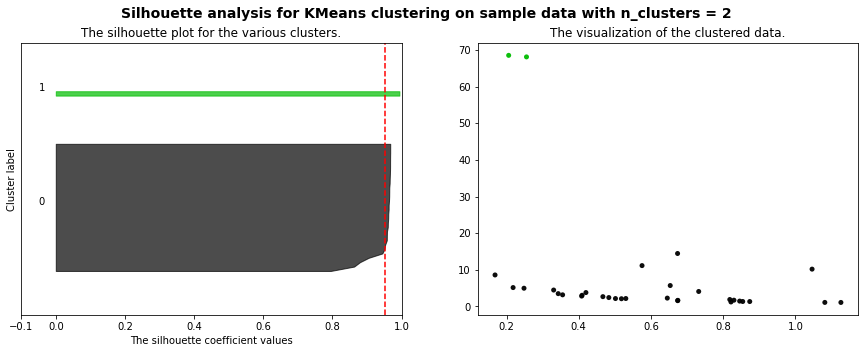

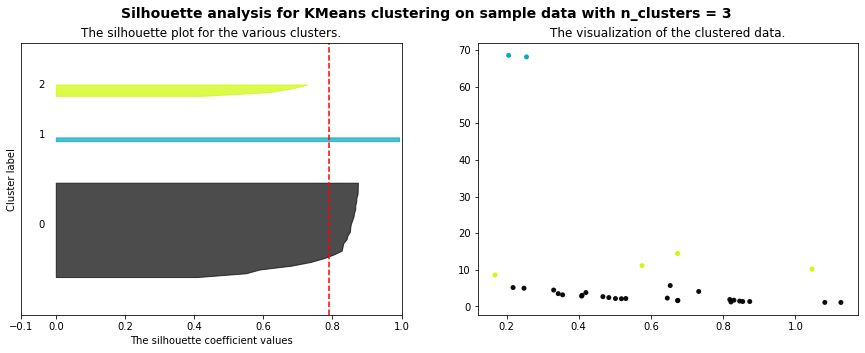

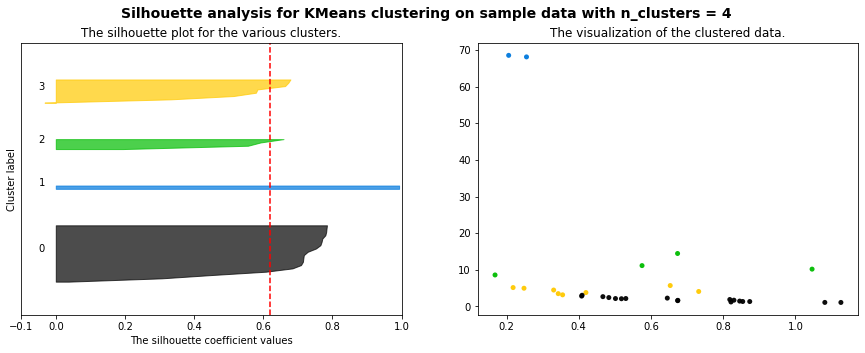

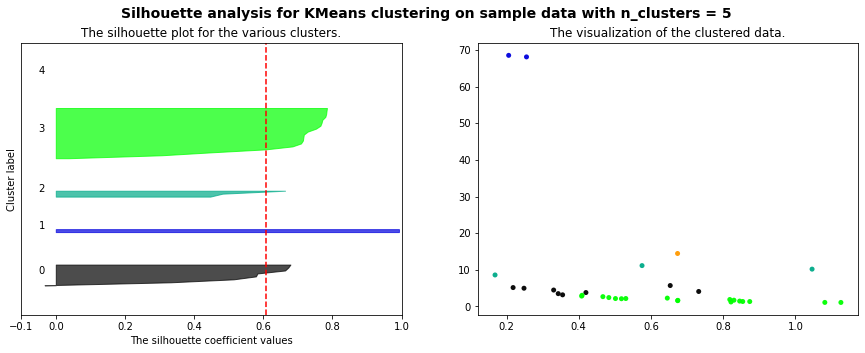

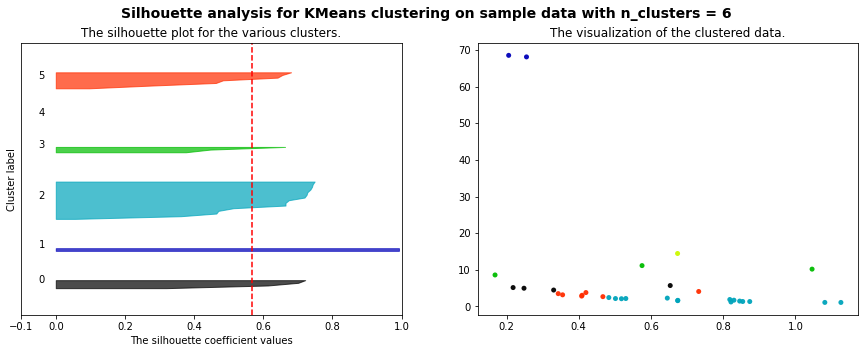

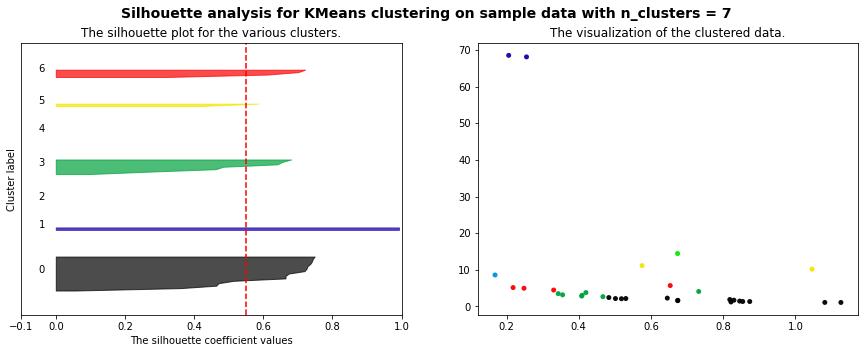

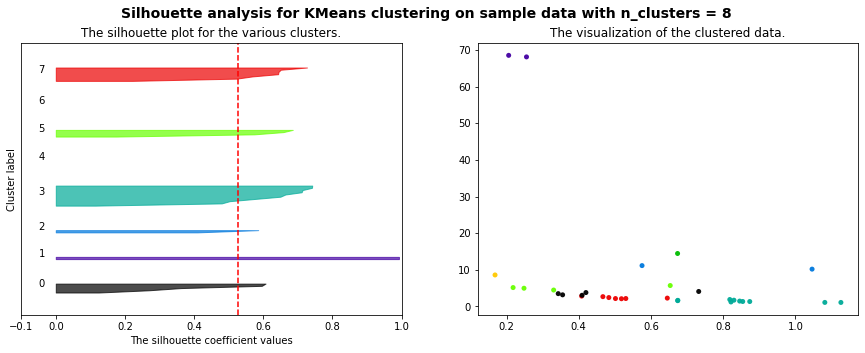

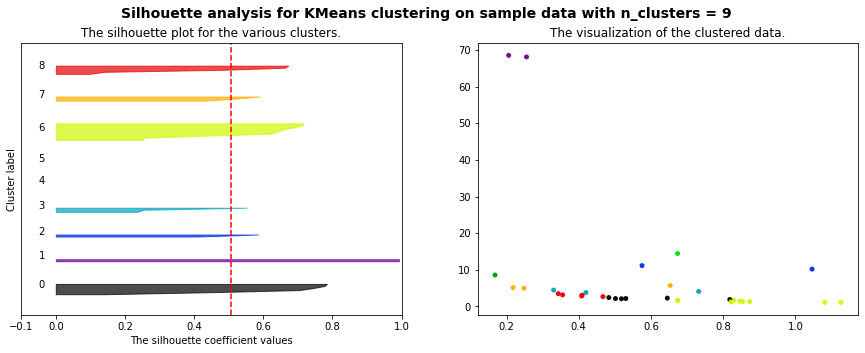

In [17]:
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(fsp_seasonal_pm10) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=8)
    cluster_labels = clusterer.fit_predict(fsp_seasonal_pm10)

    silhouette_avg = silhouette_score(fsp_seasonal_pm10, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(fsp_seasonal_pm10, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    clrs = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(fsp_seasonal_pm10['sep'], fsp_seasonal_pm10['fim'], marker='.',
                s=100, lw=0, alpha=0.95, c=clrs, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()